# **Data science for genetic data analysis and disease prediction - Part 2**
### [*DS4HB 2025 - Tutorial 1.1*](https://www.ds4hb.polimi.it/program.html#tutorial11-details)
### [*Andrea Mario Vergani*](https://humantechnopole.it/en/people/andrea-mario-vergani/), [*Andrea Lampis*](https://humantechnopole.it/en/people/andrea-lampis/) *(Politecnico di Milano, Human Technopole)*

In this Part 2 of our tutorial, we will learn how to **investigate the biological relevance** behind the raw results of a Genome-Wide Association Study (GWAS), with a particular attention to known and novel associations between an endpoint and genetic variants (SNPs) / genes.

*Python* is the programming language used in this notebook.

In [ ]:
import requests  # manages data transfer from the GWAS Catalog REST API
import json  # handles JSON data
import pandas as pd  # for data analysis and management

%pip install bioinfokit
from bioinfokit import visuz  # creates biological plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.4-py3-none-any.whl size=59220 sha256=334bcb44e8d377b6f3144567501d097ab51d831831b03dc402366ab67093da61
  Stored in directory: /root/.cache/pip/wheels/83/cd/9c/8605a43f2310bfb74df791d943a9b3aef65377ed484de98bdc
Successfully built bioinfokit


## GWAS summary statistics (GWAS Catalog)

Let's load the **summary statistics** from a **published GWAS** from GWAS Catalog [1], a well-known catalog of human genome-wide association studies.

**Summary statistics are simply the output of a GWAS:** effect and significance of each SNP in the analysis.

* [**GWAS Catalog**](https://www.ebi.ac.uk/gwas/)
* Selected study: [*GCST000028*](https://www.ebi.ac.uk/gwas/studies/GCST000028)

We will analyze the summary statistics about **type 2 diabetes** from this 2007 Science **paper** [2]

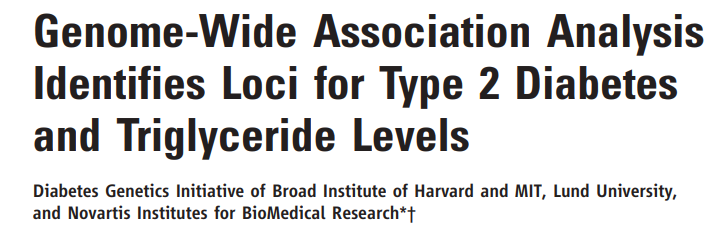

In [ ]:
### Download (harmonized) summary statistics (GRCh38)
!mkdir sumstats
!wget https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST000001-GCST001000/GCST000028/harmonised/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml
!wget https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST000001-GCST001000/GCST000028/harmonised/17463246-GCST000028-EFO_0001360.h.tsv.gz -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz
!gunzip sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz

--2025-04-07 13:43:28--  https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST000001-GCST001000/GCST000028/harmonised/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811 [text/tab-separated-values]
Saving to: ‘sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml’

sumstats/17463246-G 100%[===================>]     811  --.-KB/s    in 0s      

2025-04-07 13:43:28 (531 MB/s) - ‘sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml’ saved [811/811]

--2025-04-07 13:43:28--  https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST000001-GCST001000/GCST000028/harmonised/17463246-GCST000028-EFO_0001360.h.tsv.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, await

In [ ]:
### BACKUP - Download (harmonized) summary statistics (GRCh38)
'''
!mkdir sumstats
!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/data/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml?raw=true --content-disposition -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml
!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/data/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz?raw=true --content-disposition -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz
!gunzip sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz
'''

'\n!mkdir sumstats\n!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/data/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml?raw=true --content-disposition -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml\n!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/data/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz?raw=true --content-disposition -O sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz\n!gunzip sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz\n'

* /content/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml specifies some useful information (genome assembly, sample size, ...)
* /content/sumstats/17463246-GCST000028-EFO_0001360.h.tsv contains the full summary statistics

In [ ]:
### Load summary statistics
assocTable_raw = pd.read_table("sumstats/17463246-GCST000028-EFO_0001360.h.tsv", low_memory=False)
assocTable_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558610 entries, 0 to 558609
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   hm_variant_id               325810 non-null  object 
 1   hm_rsid                     325810 non-null  object 
 2   hm_chrom                    325810 non-null  object 
 3   hm_pos                      325810 non-null  float64
 4   hm_other_allele             325810 non-null  object 
 5   hm_effect_allele            325810 non-null  object 
 6   hm_beta                     0 non-null       float64
 7   hm_odds_ratio               0 non-null       float64
 8   hm_ci_lower                 0 non-null       float64
 9   hm_ci_upper                 0 non-null       float64
 10  hm_effect_allele_frequency  325810 non-null  float64
 11  hm_code                     558610 non-null  int64  
 12  chromosome                  558610 non-null  int64  
 13  base_pair_loca

The raw summary statistics contain over 550k SNPs mapped on **genome build 38** (GRCh38).

Let's preprocess the raw data!

In [ ]:
### Rename dataframe columns
columns_rename = {'variant_id': 'SNP',
                  'chromosome': 'CHR',
                  'base_pair_location': 'BP',
                  'other_allele': 'OA',
                  'effect_allele': 'EA',
                  'effect_allele_frequency': 'EAF',
                  'p_value': 'P'}  # column renaming dictionary
assocTable = assocTable_raw.rename(columns=columns_rename)  # rename columns

### Keep only useful columns
assocTable = assocTable[list(columns_rename.values())]

### Remove duplicates
assocTable = assocTable.drop_duplicates(subset='SNP', keep=False)

### Manage data types
assocTable['CHR'] = assocTable['CHR'].map(lambda x: '23' if x=='X' else x)  # changing 'X' chromosome name to 23
assocTable = assocTable.astype({'CHR': int, 'BP': int})  # cast chromosome and position to integer

### Sort by genomic coordinates
assocTable = assocTable.sort_values(axis='index', by=['CHR', 'BP'], ignore_index=True)

assocTable.info()
assocTable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558548 entries, 0 to 558547
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     558548 non-null  object 
 1   CHR     558548 non-null  int64  
 2   BP      558548 non-null  int64  
 3   OA      389103 non-null  object 
 4   EA      389103 non-null  object 
 5   EAF     389103 non-null  float64
 6   P       558548 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 29.8+ MB


,SNP,CHR,BP,OA,EA,EAF,P
0,rs3094315,1,817186,A,G,0.18440,0.27060
1,rs2980300,1,850609,C,T,0.18680,0.63200
2,rs4075116,1,1068249,T,C,0.27080,0.57070
3,rs9442385,1,1161955,G,T,0.08413,0.75860
4,rs10907175,1,1195347,A,C,0.08970,0.02220
...,...,...,...,...,...,...,...
558543,rs6420603,23,155523319,A,G,0.04962,0.08002
558544,rs5940513,23,155559835,G,A,0.25300,0.06006
558545,rs479901,23,155614626,T,A,0.25270,0.06552
558546,rs574386,23,155617828,T,C,0.25240,0.07277


In [ ]:
### Export useful information
assocTable[['SNP', 'CHR', 'BP']].to_csv("snp_chr_pos.tsv", sep="\t", header=False, index=False)  # save chromosome-position for later use
assocTable[['SNP', 'P']].to_csv("snp_pvalue.tsv", sep="\t", header=False, index=False)  # save pvalue for later use

## Manhattan plot

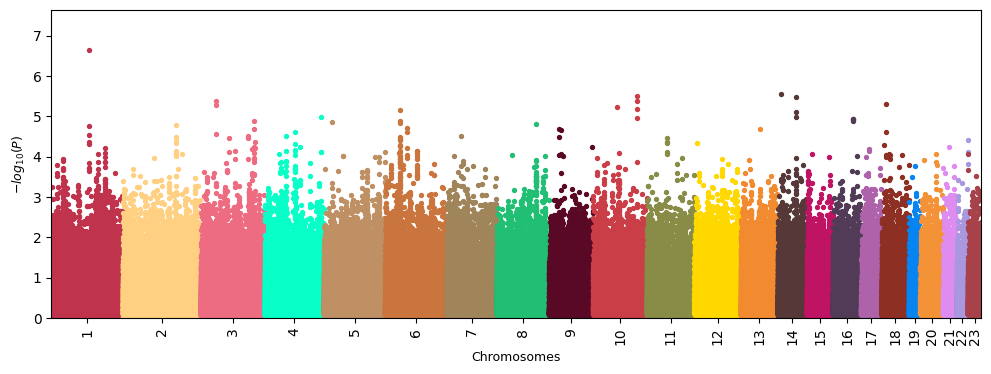

In [ ]:
### Manhattan plot
visuz.marker.mhat(df=assocTable, chr='CHR', pv='P', markeridcol='SNP', dim=(12,4), show=True)

## SNP-based biological analysis

To validate the robustness and increase the (limited) power of their findings, the authors of the original paper tried to replicate their associations in other populations, and **compare** them with **previously published results**.

Now, we will do the same, by exploring the **biological insights** of the two SNPs with the **strongest associations**.

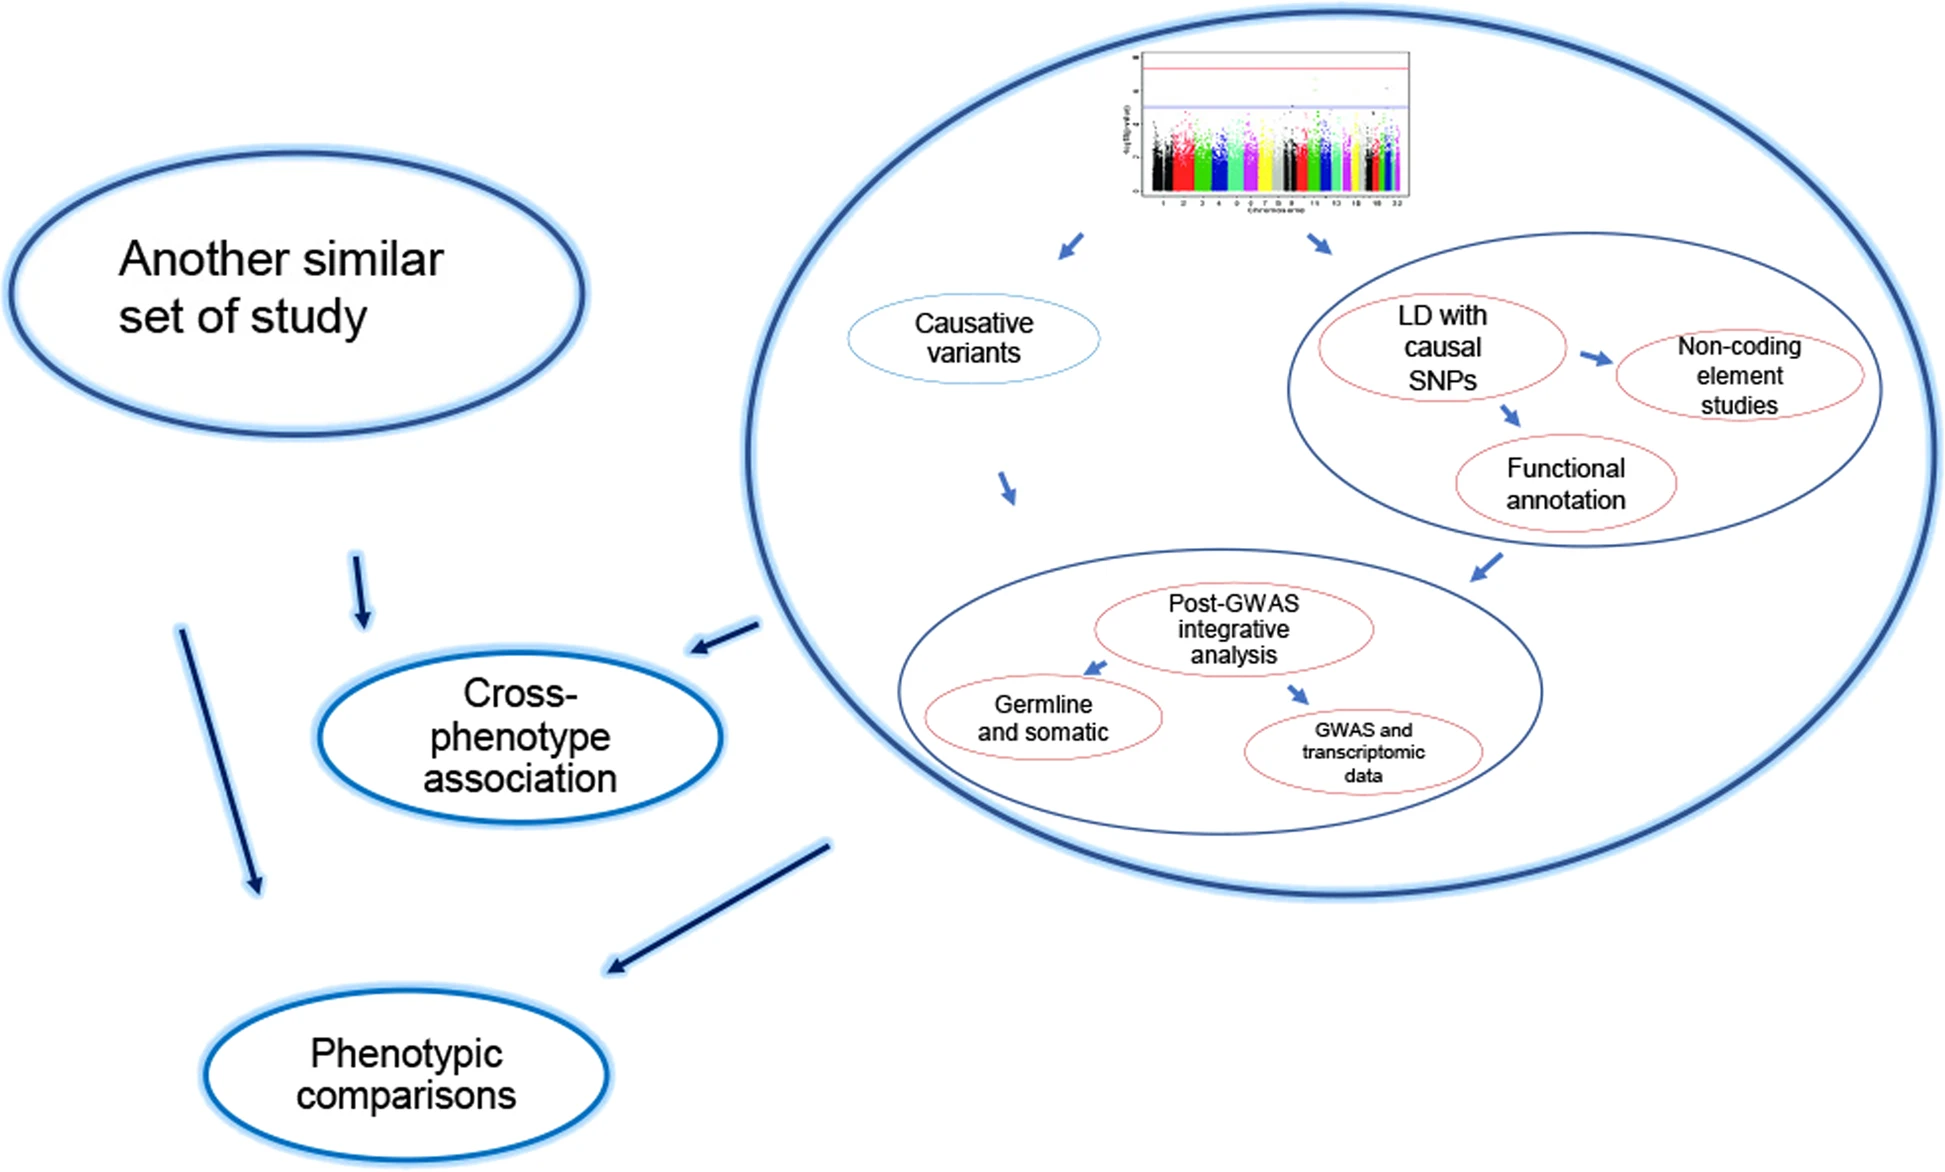

In general, if we find a **significant association** in our GWAS, this could be:
* a **known** (i.e., previously published) association, so our result confirms previous findings, ***OR***
* a **novel** (i.e., never published before) one, meaning that we may have discovered a new association.

For knowing this, we should **look at** the associations found by **previous studies** in the literature [3], just like the authors did in the original paper.

### Most significant SNP-phenotype associations

* From the Manhattan plot, we observe that two SNPs with the strongest associations are in chromosomes 1 and 14
* This is confirmed by inspecting the association table (see below):
  * SNP **rs10923931**, in chromosome 1, has the **strongest association** (lowest p-value)
  * SNP **rs1211216**, in chromosome 14, has the **second strongest association** (second lowest p-value)

In [ ]:
assocTable.sort_values(axis='index', by='P')

,SNP,CHR,BP,OA,EA,EAF,P,tpval
22520,rs10923931,1,119975336,G,T,0.09695,2.300000e-07,6.638272
438292,rs1211216,14,29543459,T,C,0.25480,2.810000e-06,5.551294
352123,rs4506565,10,112996282,A,T,0.23620,3.050000e-06,5.515700
447479,rs11621202,14,75313377,C,T,0.23720,3.270000e-06,5.485452
352122,rs7901695,10,112994329,T,C,0.23430,4.140000e-06,5.383000
...,...,...,...,...,...,...,...,...
460520,rs8038241,15,58153856,NaN,NaN,NaN,9.978000e-01,0.000957
63981,rs6732190,2,101436901,NaN,NaN,NaN,9.989000e-01,0.000478
334875,rs1923272,10,33079576,NaN,NaN,NaN,9.992000e-01,0.000348
41130,rs13375303,1,238237617,NaN,NaN,NaN,9.992000e-01,0.000348


### rs10923931's biology

#### [GWAS Catalog](https://www.ebi.ac.uk/gwas/)

https://www.ebi.ac.uk/gwas/variants/rs10923931

* The variant was found to be **associated with type 2 diabetes** also in **other studies**: published association

#### [OpenTargets Genetics](https://genetics.opentargets.org/)

https://genetics.opentargets.org/Variant/1_119975336_G_T/associations [4, 5]

* Variant information and allele frequencies
* Nearest (coding) gene
* Mapped gene(s)
* PheWas **confirms** that the variant is **associated with type 2 diabetes** (and other diseases)

#### [VarChat](https://varchat.engenome.com/)

Copying the variant ID as a prompt, the **generative AI assistant** provides a description of the variant, its associations in the literature, and references [6]

### rs1211216's biology

#### [GWAS Catalog](https://www.ebi.ac.uk/gwas/)

https://www.ebi.ac.uk/gwas/search?query=rs1211216

* Variant **not even found** on GWAS Catalog: no significant associations from other studies

##### API access

In [ ]:
### Get SNP known associations (p-value <= 1e-3) from GWAS Catalog
apiUrl = 'https://www.ebi.ac.uk/gwas/summary-statistics/api'  # API Address
variant = 'rs1211216'  # variant ID

requestUrl = f'{apiUrl}/associations/{variant}?p_upper={1e-3}'  # https://www.ebi.ac.uk/gwas/summary-statistics/docs/
extractedData = []


while True:  # get data with multiple requests (limited size for a single request)
  response = requests.get(requestUrl)  # query GWAS Catalog (REST API)
  # The returned response is a "response" object, from which we have to extract and parse the information
  decoded = response.json()  # extract and parse response information

  # decoded['_embedded']['associations'] contains genetic associations
  for association in decoded['_embedded']['associations'].values():
    # Save current association
    extractedData.append({'SNP' : association['variant_id'],
                          'CHR' : association['chromosome'],
                          'BP' : association['base_pair_location'],
                          'EA' : association['effect_allele'],
                          'OA' : association['other_allele'],
                          'BETA' : association['beta'],
                          'OR' : association['odds_ratio'],
                          'CI_LOW' : association['ci_lower'],
                          'CI_UP' : association['ci_upper'],
                          'P' : association['p_value'],
                          'EAF' : association['effect_allele_frequency'],
                          'STUDY': association['study_accession']})

  # decoded['_links']['next'] contains the API URL for the next chunk of data
  if 'next' in decoded['_links'].keys():  # next request
    requestUrl = decoded['_links']['next']['href']
  else:  # all the data have been downloaded: stop
    break

In [ ]:
### Known associations dataframe
assocTable = pd.DataFrame.from_dict(extractedData).sort_values(axis='index', by='P', ignore_index=True)

assocTable

,SNP,CHR,BP,EA,OA,BETA,OR,CI_LOW,CI_UP,P,EAF,STUDY
0,rs1211216,14,29543459,C,T,NaN,None,None,None,0.000003,0.254800,GCST000028
1,rs1211216,14,29543459,C,T,NaN,None,None,None,0.000470,NaN,GCST006476
2,rs1211216,14,29543459,C,T,-0.008564,None,None,None,0.000768,0.285013,GCST006940
3,rs1211216,14,29543459,C,T,-0.008719,None,None,None,0.000957,NaN,GCST006478


We observe that the variant showed a *p-value <= 1e-3* in only three other studies (the first row is "our" study).

However, the variant was **never observed** to have **genome-wide significant associations** in any GWAS Catalog study.

#### [OpenTargets Genetics](https://genetics.opentargets.org/)

https://genetics.opentargets.org/Variant/14_29543459_T_C/associations

* Variant information and allele frequencies
* Nearest (coding) gene
* Mapped gene(s)
* According to PheWas, the variant is **novel for diabetes**: only previously associated with bisoprolol intake (against hypertension and heart failure)

#### [VarChat](https://varchat.engenome.com/)

Copying the variant ID as a prompt, the generative AI assistant **does not find any relevant information**: again, this goes in the direction of a **novel discovery**!

## Gene-based analysis

Gene-based analysis of GWAS data is an analysis **testing the genetic associations of genes with a phenotype** (i.e., "GWAS" using genes as data points instead of SNPs) [7].

The picture below [8] shows that only a **limited portion of DNA** falls in gene regions.

A **gene** is the basic unit of inheritance, passed from parents to offspring and containing the information needed to specify physical and biological traits. Most genes code for specific proteins; humans have approximately **20,000 protein-coding genes** (accounting for about 1.5% of the entire human genome) [9].

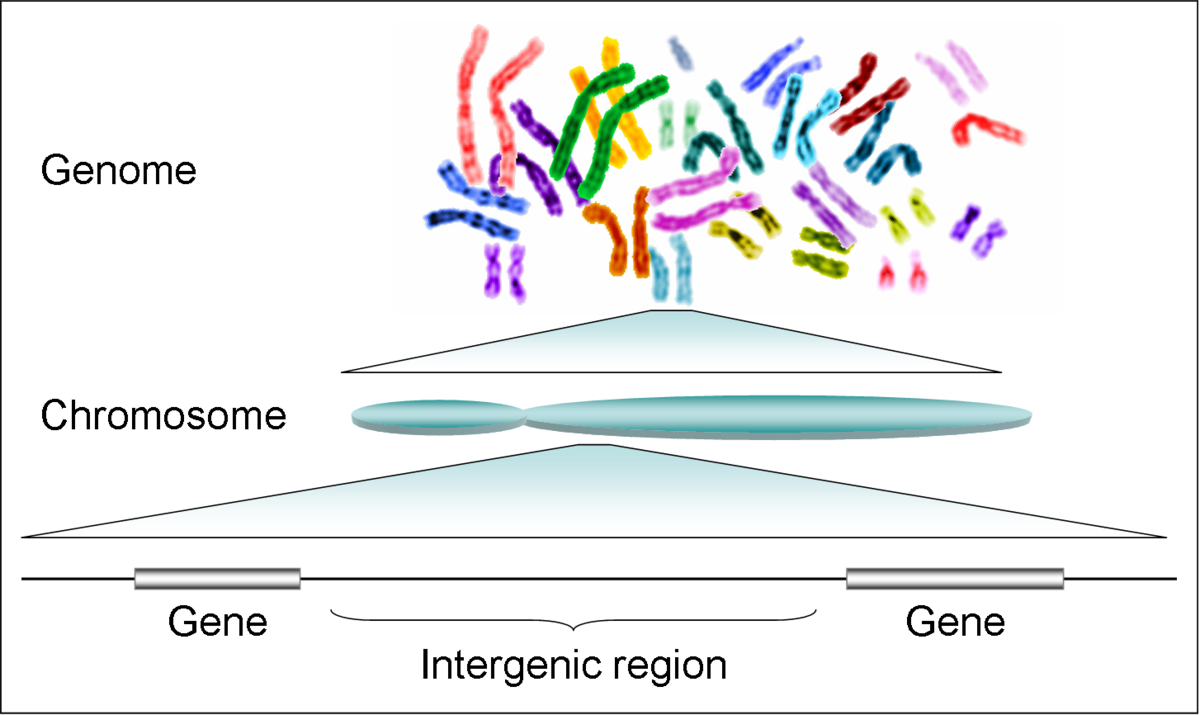

For this reason, **most** of our **SNPs** will **not belong** to any gene.

However, they can have regulatory functions and, as we know, may still contribute to phenotype definition!

### MAGMA (and auxiliary files)

* [**MAGMA**](https://cncr.nl/research/magma/)
* [*Manual*](https://vu.data.surfsara.nl/index.php/s/MUiv3y1SFRePnyG)

MAGMA [10] is a statistical method for analyzing **multiple genetic markers simultaneously** to determine their joint effect.

In this way, the effects of individually weak markers are grouped together, potentially improving statistical power. Moreover, MAGMA analyses may provide additional insights into functional and biological mechanisms underlying the genetic components of a trait.

In [ ]:
### Download MAGMA and auxiliary files

# MAGMA
!mkdir magma
!wget https://vu.data.surfsara.nl/index.php/s/zkKbNeNOZAhFXZB/download -O magma/magma_v1.10.zip
!unzip magma/magma_v1.10.zip -d magma/

# Gene locations (build 38)
!mkdir NCBI38
!wget https://vu.data.surfsara.nl/index.php/s/yj952iHqy5anYhH/download -O NCBI38/NCBI38.zip
!unzip NCBI38/NCBI38.zip -d NCBI38/

# SNP synonyms (dbSNP 151)
!mkdir dbsnp151
!wget https://vu.data.surfsara.nl/index.php/s/MSeFJuAVKJ4HLHv/download -O dbsnp151/dbsnp151.synonyms.zip
!unzip dbsnp151/dbsnp151.synonyms.zip -d dbsnp151/

# European reference data
!mkdir g1000_eur
!wget https://vu.data.surfsara.nl/index.php/s/VZNByNwpD8qqINe/download -O g1000_eur/g1000_eur.zip
!unzip g1000_eur/g1000_eur.zip -d g1000_eur/

--2025-04-07 14:05:48--  https://vu.data.surfsara.nl/index.php/s/zkKbNeNOZAhFXZB/download
Resolving vu.data.surfsara.nl (vu.data.surfsara.nl)... 145.107.8.10, 145.107.56.10, 145.100.60.10
Connecting to vu.data.surfsara.nl (vu.data.surfsara.nl)|145.107.8.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2629984 (2.5M) [application/zip]
Saving to: ‘magma/magma_v1.10.zip’

magma/magma_v1.10.z 100%[===================>]   2.51M  4.17MB/s    in 0.6s    

2025-04-07 14:05:49 (4.17 MB/s) - ‘magma/magma_v1.10.zip’ saved [2629984/2629984]

Archive:  magma/magma_v1.10.zip
  inflating: magma/magma             
  inflating: magma/README            
  inflating: magma/CHANGELOG         
  inflating: magma/manual_v1.10.pdf  
--2025-04-07 14:05:49--  https://vu.data.surfsara.nl/index.php/s/yj952iHqy5anYhH/download
Resolving vu.data.surfsara.nl (vu.data.surfsara.nl)... 145.107.8.10, 145.107.56.10, 145.100.60.10
Connecting to vu.data.surfsara.nl (vu.data.surfsara.nl)|145.107.

In [ ]:
### BACKUP - Download MAGMA and auxiliary files
'''
# MAGMA
!mkdir magma
!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/magma_v1.10.zip?raw=true --content-disposition -O magma/magma_v1.10.zip
!unzip magma/magma_v1.10.zip -d magma/

# Gene locations (build 38)
!mkdir NCBI38
!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/NCBI38.zip?raw=true --content-disposition -O NCBI38/NCBI38.zip
!unzip NCBI38/NCBI38.zip -d NCBI38/

# SNP synonyms (dbSNP 151)
!mkdir dbsnp151
!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/dbsnp151.synonyms.zip?raw=true --content-disposition -O dbsnp151/dbsnp151.synonyms.zip
!unzip dbsnp151/dbsnp151.synonyms.zip -d dbsnp151/

# European reference data
!mkdir g1000_eur
!wget https://vu.data.surfsara.nl/index.php/s/VZNByNwpD8qqINe/download -O g1000_eur/g1000_eur.zip
!unzip g1000_eur/g1000_eur.zip -d g1000_eur/
'''

'\n# MAGMA\n!mkdir magma\n!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/magma_v1.10.zip?raw=true --content-disposition -O magma/magma_v1.10.zip\n!unzip magma/magma_v1.10.zip -d magma/\n\n# Gene locations (build 38)\n!mkdir NCBI38\n!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/NCBI38.zip?raw=true --content-disposition -O NCBI38/NCBI38.zip\n!unzip NCBI38/NCBI38.zip -d NCBI38/\n\n# SNP synonyms (dbSNP 151)\n!mkdir dbsnp151\n!wget https://github.com/ht-diva/ds4hb_workshop_t1_1/blob/main/tools/dbsnp151.synonyms.zip?raw=true --content-disposition -O dbsnp151/dbsnp151.synonyms.zip\n!unzip dbsnp151/dbsnp151.synonyms.zip -d dbsnp151/\n\n# European reference data\n!mkdir g1000_eur\n!wget https://vu.data.surfsara.nl/index.php/s/VZNByNwpD8qqINe/download -O g1000_eur/g1000_eur.zip\n!unzip g1000_eur/g1000_eur.zip -d g1000_eur/\n'

In [ ]:
### Load gene locations (NCBI38)
genes = pd.read_table("NCBI38/NCBI38.gene.loc", header=None).rename(columns={0: 'ID',
                                                                             1: 'CHR',
                                                                             2: 'BP_START',
                                                                             3: 'BP_END',
                                                                             4: 'STRAND',
                                                                             5: 'GENE'})
genes

,ID,CHR,BP_START,BP_END,STRAND,GENE
0,79501,1,69091,70008,+,OR4F5
1,100996442,1,141934,174394,-,LOC100996442
2,102725121,1,181045,184254,+,LOC102725121
3,102723897,1,184916,200470,-,LOC102723897
4,729759,1,450740,451678,-,OR4F29
...,...,...,...,...,...,...
20132,442867,Y,24618004,24639207,+,BPY2B
20133,57054,Y,24763069,24813505,-,DAZ3
20134,57135,Y,24833800,24907040,+,DAZ4
20135,442868,Y,25030901,25052104,-,BPY2C


MAGMA (basic) steps:
1.   **Annotation:** map SNPs onto genes
2.   **Gene analysis:** compute gene p-values

### Step 1: Annotate SNPs to genes (MAGMA)

Annotation can be simply performed via the **`--annotate`** command, passing the following arguments:
* `--snp-loc FILE` for **our SNPs** and their **positions** (we have previously saved this file in /content/snp_chr_pos.tsv)
* `--gene-loc FILE` for **gene locations** (NCBI38 downloaded from the MAGMA website, in /content/NCBI38/NCBI38.gene.loc)

In [ ]:
!./magma/magma --annotate --snp-loc snp_chr_pos.tsv --gene-loc NCBI38/NCBI38.gene.loc

Welcome to MAGMA v1.10 (linux)
Using flags:
	--annotate
	--snp-loc snp_chr_pos.tsv
	--gene-loc NCBI38/NCBI38.gene.loc

Start time is 14:10:40, Monday 07 Apr 2025

Starting annotation...
Reading gene locations from file NCBI38/NCBI38.gene.loc... 
	20137 gene locations read from file
	chromosome  1: 2097 genes
	chromosome  2: 1285 genes
	chromosome  3: 1078 genes
	chromosome  4: 765 genes
	chromosome  5: 886 genes
	chromosome  6: 1053 genes
	chromosome  7: 942 genes
	chromosome  8: 691 genes
	chromosome  9: 803 genes
	chromosome 10: 748 genes
	chromosome 11: 1299 genes
	chromosome 12: 1032 genes
	chromosome 13: 341 genes
	chromosome 14: 613 genes
	chromosome 15: 616 genes
	chromosome 16: 865 genes
	chromosome 17: 1197 genes
	chromosome 18: 283 genes
	chromosome 19: 1423 genes
	chromosome 20: 540 genes
	chromosome 21: 246 genes
	chromosome 22: 461 genes
	chromosome  X: 825 genes
	chromosome  Y: 48 genes
Reading SNP locations from file snp_chr_pos.tsv... 
	558548 SNP locations read from fi

Almost **15k genes** (out of about 20k) have **at least one** of our **SNPs mapped** to it

**/content/magma.genes.annot** now contains the **annotations** of our **SNPs to the genes**. In our case, a SNP is annotated to a gene only if it falls within the gene region (i.e., no regulatory effects considered here)

### Step 2: Gene analysis (MAGMA)

In this tutorial, we will perform the **SNP-wise (weighted) mean** analysis to test the joint association of all markers in a gene with our phenotype of interest [11]:
* We will start from our **GWAS summary statistics**
* **Gene-phenotype associations** will be calculated **aggregating SNP-phenotype associations** for all the SNPs in the considered gene
* The analysis will take into account **Linkage Disequilibrium** (LD), which is related to the correlation between SNPs close by in the genome (and inherited together)

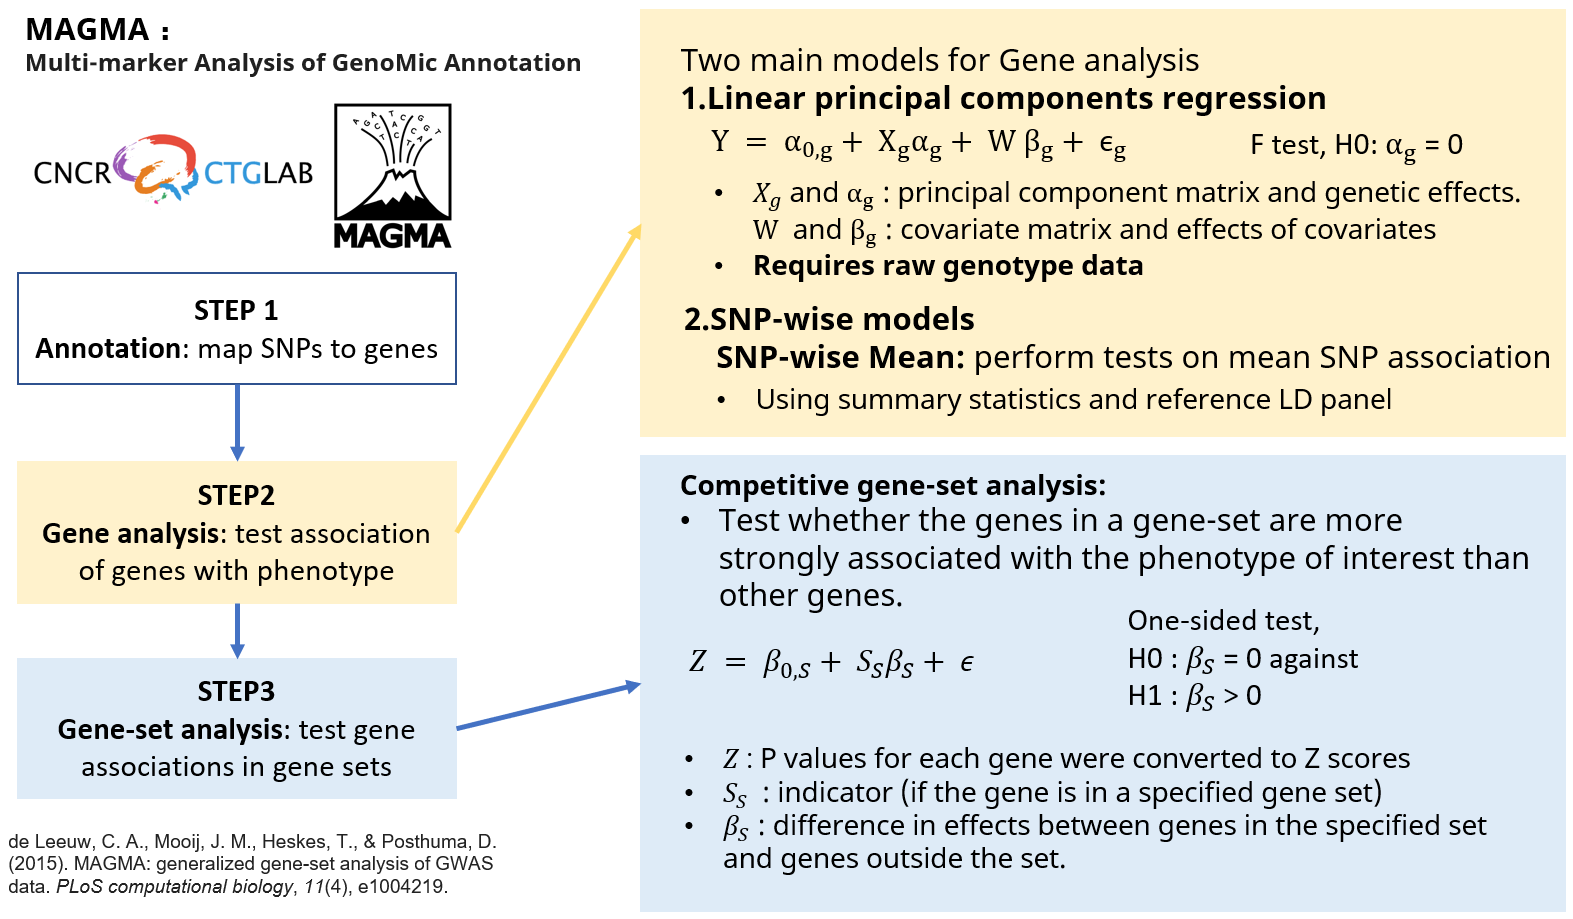

For the analysis, we run MAGMA passing:
* `--bfile FILE` for **reference genetic data** used to account for linkage disequilibrium between SNPs (European g1000 downloaded from the MAGMA website, in /content/g1000_eur)
  * Optionally specifying `synonyms=dbsnp151/dbsnp151.synonyms` for using dbsnp151 SNP synonyms instead of g1000 ones (/content/g1000_eur/g1000_eur.synonyms)
* `--pval FILE` for **our SNPs** and their **pvalues**, specifying `N=COHORT_SAMPLE_SIZE` (we have previously saved this file in /content/snp_pvalue.tsv)
  * The value for `COHORT_SAMPLE_SIZE` can be found in /content/sumstats/17463246-GCST000028-EFO_0001360.h.tsv.gz-meta.yaml
* `--gene-annot FILE` for the previously **annotated SNPs to genes** (/content/magma.genes.annot)
* `--genes-only` if this is our last analysis with MAGMA (basic, i.e., no Step 3)

In [ ]:
!./magma/magma --bfile g1000_eur/g1000_eur --pval snp_pvalue.tsv N=2931 --gene-annot magma.genes.annot --genes-only

Welcome to MAGMA v1.10 (linux)
Using flags:
	--bfile g1000_eur/g1000_eur
	--pval snp_pvalue.tsv N=2931
	--gene-annot magma.genes.annot
	--genes-only

Start time is 14:14:14, Monday 07 Apr 2025

Loading PLINK-format data...
Reading file g1000_eur/g1000_eur.fam... 503 individuals read
Reading file g1000_eur/g1000_eur.bim... 22665064 SNPs read
Preparing file g1000_eur/g1000_eur.bed... 

Reading SNP synonyms from file g1000_eur/g1000_eur.synonyms (auto-detected)
	read 6016767 mapped synonyms from file, mapping to 3921040 SNPs in the data
	         skipped all synonym entries involved, synonymous SNPs are kept in analysis
	         writing list of detected synonyms in data to supplementary log file
Reading SNP p-values from file snp_pvalue.tsv... 
	detected 2 variables in file
	using variable: variable 1 (SNP id)
	using variable: variable 2 (p-value)
	read 558548 lines from file, containing valid SNP p-values for 552318 SNPs in data (98.88% of lines, 2.437% of SNPs in data)
Loading gene ann

**/content/magma.genes.out** now contains our **gene analysis results**!

In [ ]:
gene_p = pd.read_table("magma.genes.out", sep="\s+").sort_values(axis='index', by=['P'])
gene_p

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
5033,10665,6,32288541,32372114,27,5,2931,4.6055,0.000002
797,4853,1,119911553,120069703,13,3,2931,4.2025,0.000013
3643,57482,4,56049229,56330724,65,24,2931,4.1174,0.000019
6741,9694,8,108443624,108486907,13,3,2931,4.0600,0.000025
4469,11127,5,132689161,132737633,6,2,2931,3.9571,0.000038
...,...,...,...,...,...,...,...,...,...
12090,27092,17,66964864,67033402,9,4,2931,-2.2627,0.988170
6863,7436,9,2621679,2656100,12,5,2931,-2.2741,0.988520
3560,116984,4,36065998,36244357,21,5,2931,-2.2995,0.989260
11583,59344,17,8095900,8118916,9,4,2931,-2.4617,0.993090


In [ ]:
# Let's inspect the gene with the strongest association (ID=10665)
genes[genes['ID'] == 10665]  # gene C6orf10 (ID=10665)

,ID,CHR,BP_START,BP_END,STRAND,GENE
16118,10665,6,32288541,32372114,-,C6orf10


We observe that:
* **Gene C6orf10** (ID=10665, 6:32288541:32372114) - now known as *TSBP1* [12] - has the **strongest association** (lowest p-value)
* Several SNPs mapped to it

### TSBP1 (C6orf10)'s biology

#### [GWAS Catalog](https://www.ebi.ac.uk/gwas/)

https://www.ebi.ac.uk/gwas/genes/TSBP1

* The gene was found to be **associated with diabetes** (in other studies)

#### [OpenTargets Genetics](https://genetics.opentargets.org/)

https://genetics.opentargets.org/Gene/ENSG00000204296/associations

* Gene information
* Associations (also diabetes)

#### [OpenTargets Platform](https://platform.opentargets.org/)

https://platform.opentargets.org/target/ENSG00000204296/ [13]

* Gene description
* Expression
* Molecular interactions
* ...
* Bibliography

https://platform.opentargets.org/target/ENSG00000204296/associations

* Besides diabetes and cardiometabolic diseases, **many other phenotypes** have been found to be associated with this gene

#### [VarChat](https://varchat.engenome.com/)

Copying the gene name as a prompt, the **generative AI assistant** provides a description of the gene, its biological role, its main associations in the literature, and references

# References and credits

1. Cerezo et al. (2025), "The NHGRI-EBI GWAS Catalog: standards for reusability, sustainability and diversity". https://doi.org/10.1093/nar/gkae1070
2. Saxena et al. (2007), "Genome-Wide Association Analysis Identifies Loci for Type 2
Diabetes and Triglyceride Levels". https://doi.org/10.1126/science.1142358
3. Mortezaei, Tavallaei (2021), "Recent innovations and in-depth aspects of post-genome wide association study (Post-GWAS) to understand the genetic basis of complex phenotypes". https://doi.org/10.1038/s41437-021-00479-w
4. Ghoussaini et al. (2021), "Open Targets Genetics: systematic identification of trait-associated genes using large-scale genetics and functional genomics". https://doi.org/10.1093/nar/gkaa840
5. Mountjoy et al. (2021), "An open approach to systematically prioritize causal variants and genes at all published human GWAS trait-associated loci". https://doi.org/10.1038/s41588-021-00945-5
6. De Paoli et al. (2024), "VarChat: the generative AI assistant for the interpretation of human genomic variations". https://doi.org/10.1093/bioinformatics/btae183
7. de Leeuw et al. (2016), "The statistical properties of gene-set analysis". https://doi.org/10.1038/nrg.2016.29
8. Wikipedia (2005), "Human genome to genes". https://en.wikipedia.org/wiki/File:Human_genome_to_genes.png
9. National Human Genome Research Institute (2025), "Gene". https://www.genome.gov/genetics-glossary/Gene
10. de Leeuw et al. (2015), "MAGMA: Generalized Gene-Set Analysis of GWAS Data". https://doi.org/10.1371/journal.pcbi.1004219
11. Laboratory of Complex Trait Genomics - Kamatani Lab (2024), "GWAS Tutorial". https://cloufield.github.io/GWASTutorial/
12. Wikipedia (2025), "TSBP1". https://en.wikipedia.org/wiki/TSBP1
13. Buniello et al. (2025), "Open Targets Platform: facilitating therapeutic hypotheses building in drug discovery". https://doi.org/10.1093/nar/gkae1128

# Acknowledgements

We would like to acknowledge:
* The [*Di Angelantonio & Ieva Group*](https://humantechnopole.it/en/research-groups/di-angelantonio-ieva-group/) @ Health Data Science Centre, Human Technopole
* Politecnico di Milano, in particular the support by MUR, grant *Dipartimento di Eccellenza 2023-2027*

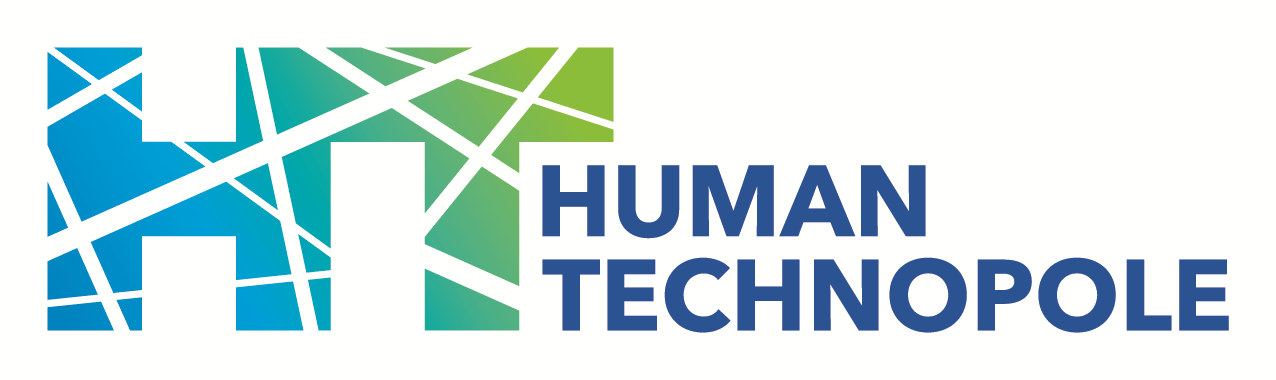

silver-polimi_dip_eccellenza.svg